# Keras for Text Classification

## Learning Objectives
1. Learn how to create a text classification datasets using BigQuery.
1. Learn how to tokenize and integerize a corpus of text for training in Keras.
1. Learn how to do one-hot-encodings in Keras.
1. Learn how to use embedding layers to represent words in Keras.
1. Learn about the bag-of-word representation for sentences.
1. Learn how to use DNN/CNN/RNN model to classify text in keras.

## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/keras_for_text_classification.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

In [12]:
import os

from google.cloud import bigquery
import pandas as pd

In [13]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [20]:
PROJECT = "qwiklabs-gcp-00-0f5e3bdbeaec"  # Replace with your PROJECT
BUCKET = PROJECT 
REGION = "us-central1"  

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://console.cloud.google.com/bigquery?project=bigquery-public-data&page=table&t=stories&d=hacker_news&p=bigquery-public-data&redirect_from_classic=true) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [21]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,http://blog.wyeworks.com/2010/7/1/railsconf-20...,RailsConf 2010: Interview with Fabio Akita,16
1,http://techcrunch.com/2014/05/07/google-acquir...,Google acquires Stackdriver,17
2,http://web.mit.edu/newsoffice/2010/hidden-vari...,More is less,29
3,http://andrewgelman.com/2011/07/12383/?utm_sou...,Grade inflation: why weren’t the instructors a...,30
4,http://www.alexa.com/data/details/traffic_deta...,YC Startup Justin.tv hits Alexa 160,37
5,http://forum.trapexit.org/viewtopic.php?p=40268,Lisp flavored Erlang,78
6,http://www.ycstartups.com/,Keep track of all the Y Combinator startups on...,78
7,http://maps.google.com/maps/ms?ie=UTF8&msa=0&m...,Airplane is tripping on Google Maps,114
8,https://github.com/adalkiran/webrtc-nuts-and-b...,"Show HN: WebRTC Nuts and Bolts, A holistic way...",124
9,https://www.nytimes.com/2018/02/12/technology/...,Google Makes Its Special A.I. Chips Available ...,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [24]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,123624
1,medium,111783
2,youtube,89728
3,nytimes,64827
4,blogspot,53082
...,...,...
95,nextplatform,2359
96,anandtech,2351
97,politico,2340
98,extremetech,2333


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [25]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [26]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,biggie-router a node.js high performance rout...,github
1,showhn - bookmarklet to rearrange comments by ...,github
2,ajaxify rails,github
3,show hn paragrai add paragraphs to badly fo...,github
4,kvs erlang data framework for n2o,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [27]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 236186 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [28]:
title_dataset.source.value_counts()

github        123624
nytimes        64827
techcrunch     47735
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [29]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [30]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [31]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        526
nytimes       287
techcrunch    187
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [32]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [33]:
sample_title_dataset.head()

,title,source
14811,show hn obfuscate any of your php code,github
151734,what happens when our faces are tracked everyw...,nytimes
168690,uneven rise for groupon in japan,nytimes
94064,chrome devtools auto save,github
105482,show hn prevent bugs from out-of-order execut...,github


In [34]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.6.5


In [35]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [36]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [37]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,cocoapods downloads max out five github server...,github
1,show hn untrusted a meta-javascript adventur...,github
2,show hn limelight - responsive beautiful the...,github
3,to understand the brutality of american capita...,nytimes
4,kodi remote os x widget,github


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [43]:
titles_df.title

0         cocoapods downloads max out five github server...
1         show hn  untrusted  a meta-javascript adventur...
2         show hn  limelight - responsive  beautiful the...
3         to understand the brutality of american capita...
4                                   kodi remote os x widget
                                ...                        
236181    trump wants a border wall. see what s in place...
236182    show hn  open source gameport adapter to conne...
236183                       a general theory of reactivity
236184             compressed hash-array mapped prefix-tree
236185    we work at the a.c.l.u. here s what we think a...
Name: title, Length: 236186, dtype: object

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [45]:
tokenizer

In [47]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[16879, 1956, 2536, 78, 1231, 32, 87, 5292],
 [8, 9, 6894, 1, 1642, 40, 3458, 111],
 [8, 9, 21081, 1137, 775, 711, 3, 1854]]

In [48]:
len(titles_df.title)

236186

In [50]:
len(integerized_titles)

236186

In [52]:
len(tokenizer.index_word)

80476

In [53]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

80476

In [56]:
tokenizer.document_count

236186

In [57]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

236186

In [60]:
integerized_titles[:2]

[[16879, 1956, 2536, 78, 1231, 32, 87, 5292],
 [8, 9, 6894, 1, 1642, 40, 3458, 111]]

In [61]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

25

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

In [63]:
sequences = tokenizer.texts_to_sequences(titles_df.title[:3])

In [64]:
sequences

[[16879, 1956, 2536, 78, 1231, 32, 87, 5292],
 [8, 9, 6894, 1, 1642, 40, 3458, 111],
 [8, 9, 21081, 1137, 775, 711, 3, 1854]]

In [104]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding='post')
    return padded_sequences

In [66]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[16879,  1956,  2536,    78,  1231,    32,    87,  5292,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    8,     9,  6894,     1,  1642,    40,  3458,   111,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    8,     9, 21081,  1137,   775,   711,     3,  1854,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)

In [67]:
titles_df.source[:4]

0     github
1     github
2     github
3    nytimes
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [68]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [105]:
# TODO 2
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    
    return one_hots

In [93]:
encode_labels(titles_df.source[:10])

classes [0, 0, 0, 1, 0, 0, 1, 2, 1, 0]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [81]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [82]:
sources_train.value_counts()

github        99030
nytimes       51811
techcrunch    38107
Name: source, dtype: int64

In [83]:
sources_valid.value_counts()

github        24594
nytimes       13016
techcrunch     9628
Name: source, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [106]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [107]:
X_train[:2]

array([[16879,  1956,  2536,    78,  1231,    32,    87,  5292,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    8,     9,  6894,     1,  1642,    40,  3458,   111,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)

In [108]:
Y_train[:2]

array([[1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [109]:
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]), # TODO 3
        Lambda(lambda x: tf.reduce_mean(x, axis=1)), # TODO 4
        Dense(N_CLASSES, activation='softmax') # TODO 5
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

In [ ]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 3

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)



2024-03-22 15:12:07.012380: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-03-22 15:12:07.012452: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-03-22 15:12:07.012508: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
 17/630 [..............................] - ETA: 6s - loss: 1.0867 - accuracy: 0.4775

2024-03-22 15:12:07.508603: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-03-22 15:12:07.508665: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-03-22 15:12:07.544162: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-03-22 15:12:07.545312: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-03-22 15:12:07.547074: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/dnn/train/plugins/profile/2024_03_22_15_12_07

2024-03-22 15:12:07.548034: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/dnn/train/plugins/profile/2024_03_22_15_12_07/instance-20240322-195224.trace.json.gz
2024-03-22 15:12:07.549443: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/dnn/train/plugins/profile

630/630 [==============================] - 6s 8ms/step - loss: 0.8551 - accuracy: 0.5915 - val_loss: 0.6622 - val_accuracy: 0.7078
Epoch 2/100
630/630 [==============================] - 4s 7ms/step - loss: 0.5515 - accuracy: 0.7752 - val_loss: 0.4831 - val_accuracy: 0.8236
Epoch 3/100
630/630 [==============================] - 4s 7ms/step - loss: 0.4196 - accuracy: 0.8524 - val_loss: 0.3925 - val_accuracy: 0.8559
Epoch 4/100
630/630 [==============================] - 4s 7ms/step - loss: 0.3480 - accuracy: 0.8758 - val_loss: 0.3455 - val_accuracy: 0.8697
Epoch 5/100
630/630 [==============================] - 5s 8ms/step - loss: 0.3064 - accuracy: 0.8885 - val_loss: 0.3184 - val_accuracy: 0.8784
Epoch 6/100
630/630 [==============================] - 5s 8ms/step - loss: 0.2785 - accuracy: 0.8979 - val_loss: 0.3009 - val_accuracy: 0.8854
Epoch 7/100
630/630 [==============================] - 5s 7ms/step - loss: 0.2577 - accuracy: 0.9050 - val_loss: 0.2884 - val_accuracy: 0.8894
Epoch 8/100

<AxesSubplot: >

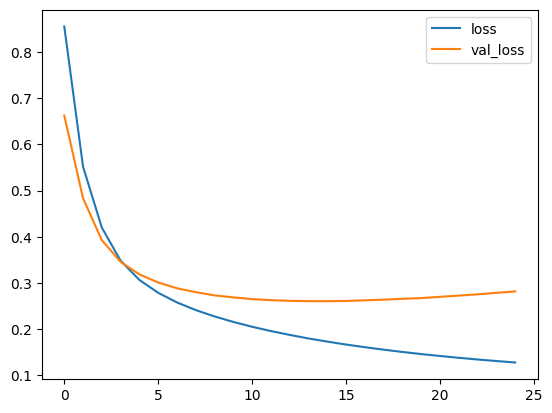

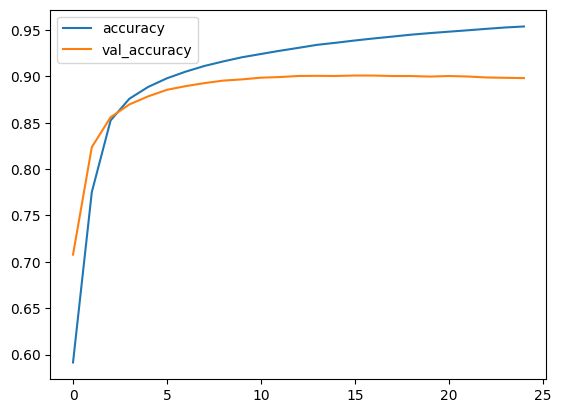

In [112]:
pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()


In [113]:

dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 25, 10)            804770    
_________________________________________________________________
lambda_4 (Lambda)            (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 804,803
Trainable params: 804,803
Non-trainable params: 0
_________________________________________________________________


## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [114]:
def build_rnn_model(embed_dim, units):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True), # TODO 3
        GRU(units), # TODO 5
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

2024-03-22 15:20:34.641896: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-03-22 15:20:34.642127: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-03-22 15:20:34.642738: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
  2/630 [..............................] - ETA: 1:32 - loss: 1.0977 - accuracy: 0.3500 

2024-03-22 15:20:38.818819: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-03-22 15:20:38.819040: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-03-22 15:20:38.939714: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-03-22 15:20:38.955028: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-03-22 15:20:38.988755: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38

2024-03-22 15:20:39.011006: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38/instance-20240322-195224.trace.json.gz


  7/630 [..............................] - ETA: 50s - loss: 1.0912 - accuracy: 0.4848 

2024-03-22 15:20:39.027766: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38

2024-03-22 15:20:39.028114: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38/instance-20240322-195224.memory_profile.json.gz
2024-03-22 15:20:39.029066: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38
Dumped tool data for xplane.pb to ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38/instance-20240322-195224.xplane.pb
Dumped tool data for overview_page.pb to ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38/instance-20240322-195224.overview_page.pb
Dumped tool data for input_pipeline.pb to ./text_models/rnn/train/plugins/profile/2024_03_22_15_20_38/instance-20240322-195224.input_pipelin

630/630 [==============================] - 24s 32ms/step - loss: 0.5035 - accuracy: 0.7685 - val_loss: 0.3125 - val_accuracy: 0.8772
Epoch 2/100
630/630 [==============================] - 20s 32ms/step - loss: 0.2438 - accuracy: 0.9073 - val_loss: 0.2639 - val_accuracy: 0.8993
Epoch 3/100
630/630 [==============================] - 19s 30ms/step - loss: 0.1823 - accuracy: 0.9323 - val_loss: 0.2662 - val_accuracy: 0.9005
Epoch 4/100
630/630 [==============================] - 19s 30ms/step - loss: 0.1515 - accuracy: 0.9450 - val_loss: 0.2764 - val_accuracy: 0.9016
Epoch 5/100
630/630 [==============================] - 20s 32ms/step - loss: 0.1312 - accuracy: 0.9534 - val_loss: 0.2963 - val_accuracy: 0.8990
Epoch 6/100
630/630 [==============================] - 19s 30ms/step - loss: 0.1160 - accuracy: 0.9588 - val_loss: 0.3049 - val_accuracy: 0.8991
Epoch 7/100
630/630 [==============================] - 20s 31ms/step - loss: 0.1025 - accuracy: 0.9637 - val_loss: 0.3260 - val_accuracy: 0.89

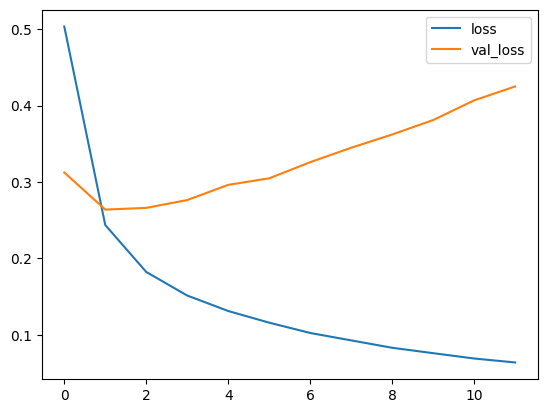

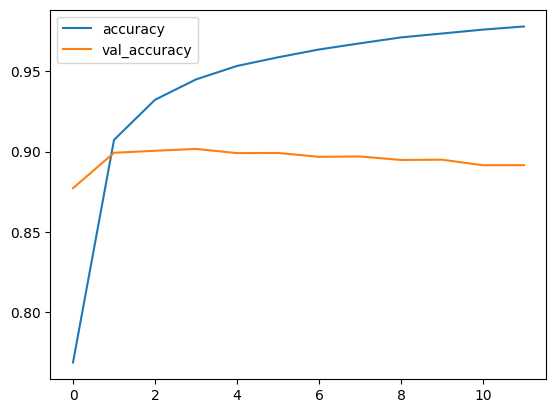

In [118]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 10

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [116]:
def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential([
        Embedding(
            VOCAB_SIZE + 1,
            embed_dim,
            input_shape=[MAX_LEN],
            mask_zero=True), # TODO 3
        Conv1D( # TODO 5
            filters=filters,
            kernel_size=ksize,
            strides=strides,
            activation='relu',
        ),
        Flatten(), # TODO 5
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



2024-03-22 15:24:31.589534: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-03-22 15:24:31.589592: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-03-22 15:24:31.589638: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
 13/630 [..............................] - ETA: 11s - loss: 1.0597 - accuracy: 0.5136

2024-03-22 15:24:32.067833: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-03-22 15:24:32.067884: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-03-22 15:24:32.143445: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-03-22 15:24:32.144376: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-03-22 15:24:32.145945: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/cnn/train/plugins/profile/2024_03_22_15_24_32

2024-03-22 15:24:32.146788: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/cnn/train/plugins/profile/2024_03_22_15_24_32/instance-20240322-195224.trace.json.gz
2024-03-22 15:24:32.148156: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/cnn/train/plugins/profile

630/630 [==============================] - 8s 12ms/step - loss: 0.4226 - accuracy: 0.8165 - val_loss: 0.2792 - val_accuracy: 0.8920
Epoch 2/100
630/630 [==============================] - 8s 12ms/step - loss: 0.2211 - accuracy: 0.9159 - val_loss: 0.2636 - val_accuracy: 0.8987
Epoch 3/100
630/630 [==============================] - 8s 12ms/step - loss: 0.1721 - accuracy: 0.9360 - val_loss: 0.2681 - val_accuracy: 0.8999
Epoch 4/100
630/630 [==============================] - 7s 12ms/step - loss: 0.1392 - accuracy: 0.9490 - val_loss: 0.2845 - val_accuracy: 0.8983
Epoch 5/100
630/630 [==============================] - 8s 12ms/step - loss: 0.1151 - accuracy: 0.9585 - val_loss: 0.3110 - val_accuracy: 0.8968
Epoch 6/100
630/630 [==============================] - 7s 12ms/step - loss: 0.0972 - accuracy: 0.9659 - val_loss: 0.3360 - val_accuracy: 0.8956
Epoch 7/100
630/630 [==============================] - 7s 11ms/step - loss: 0.0836 - accuracy: 0.9708 - val_loss: 0.3667 - val_accuracy: 0.8927
Epoc

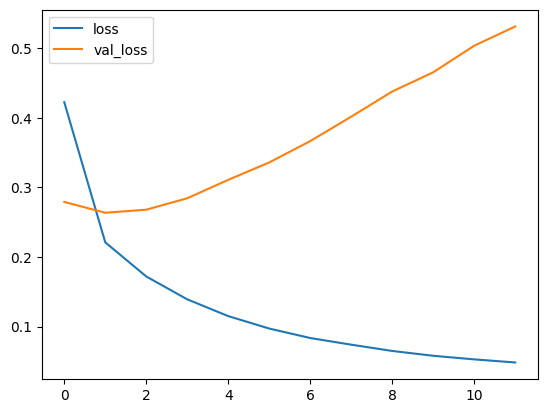

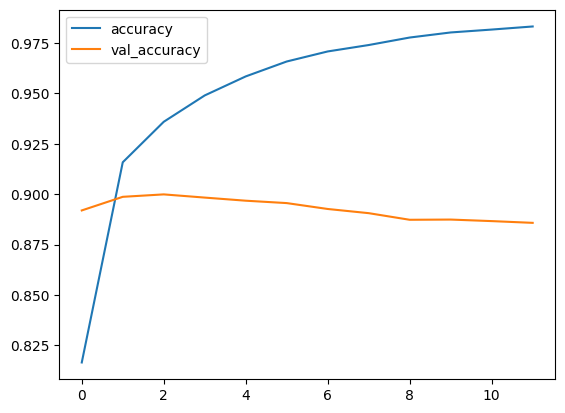

In [119]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 10


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License